In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys

import numpy as np

import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeClassifier

sys.path.insert(0, os.path.join("..", "src"))
sys.path.insert(0, os.path.join("..", "examples"))

from augmentation import TransformData
from data_generators import (
    generate_test_data_1,
    generate_test_data_3,
    generate_test_data_4,
    generate_test_data_5,
    generate_test_data_6,
    get_data_from_file,
)
from tools import run_model_for_raw_and_augmented_data, smape

import warnings

warnings.filterwarnings("ignore")

Test the models:
 - linear regression without/ with regularization

add x-fits
 - anti-correlation features
 - noise
 - low correlation features
 - test different combinations of target with features (noisy harmonic oscillations) x - sin, y - minus sin



## Data generating

In [2]:
df, train_test_split = generate_test_data_3()
df.head()

,time,x,y
0,2021-01-01 00:00:00,41.059783,90.187172
1,2021-01-01 01:00:00,46.327030,NaN
2,2021-01-01 02:00:00,44.336245,NaN
3,2021-01-01 03:00:00,49.947539,NaN
4,2021-01-01 04:00:00,60.549167,NaN


## Let's look at the data

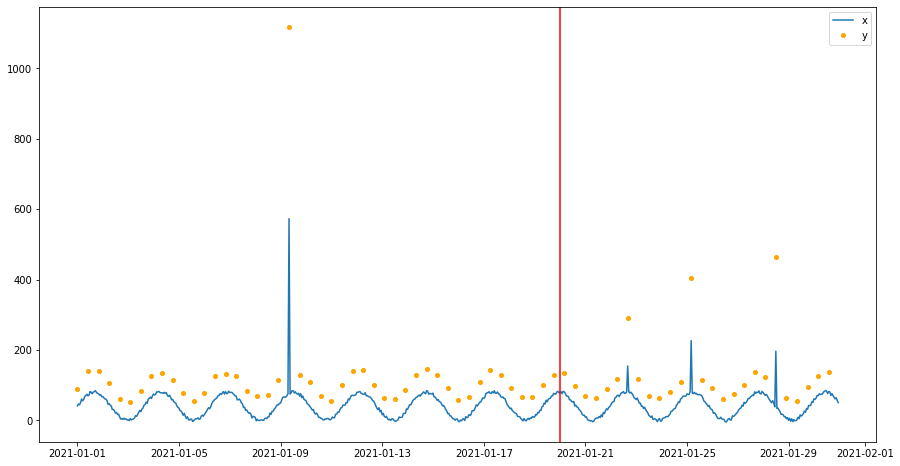

In [4]:
plt.figure(figsize=(15, 8))
x_cols = list(set(df.columns) - set(["time", "y"]))
for col in x_cols:
    plt.plot(df.time, df[col], label=col)
plt.plot(df.time, df.y, "o", markersize=4, label="y", color="orange")
plt.axvline(train_test_split, color="red")
plt.legend()

## Do calculation

In [5]:
default_model = RandomForestRegressor(n_estimators=200)
res = run_model_for_raw_and_augmented_data(
    default_model, df, train_test_split, tabgan=False
)
res.head()

,time,y,pred_raw,pred_augm
456,2021-01-20 00:00:00,NaN,136.797453,144.988220
457,2021-01-20 01:00:00,NaN,136.301507,135.683339
458,2021-01-20 02:00:00,NaN,138.097163,139.873958
459,2021-01-20 03:00:00,NaN,136.301507,135.683339
460,2021-01-20 04:00:00,135.254589,134.650005,134.472237


In [6]:
res = pd.merge(df, res.drop(columns=["y"]), on="time", how="left")
res.head()

,time,x,y,pred_raw,pred_augm
0,2021-01-01 00:00:00,41.059783,90.187172,NaN,NaN
1,2021-01-01 01:00:00,46.327030,NaN,NaN,NaN
2,2021-01-01 02:00:00,44.336245,NaN,NaN,NaN
3,2021-01-01 03:00:00,49.947539,NaN,NaN,NaN
4,2021-01-01 04:00:00,60.549167,NaN,NaN,NaN


## Build all charts

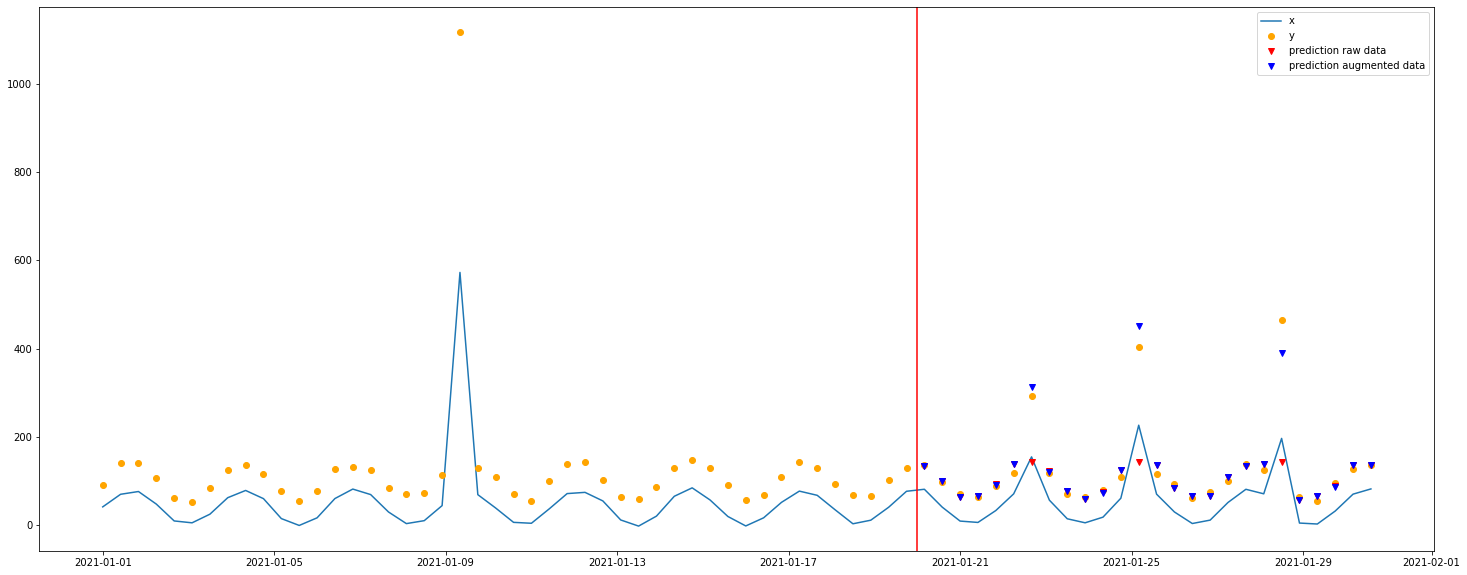

In [7]:
d = res[~np.isnan(res.y)]
plt.figure(figsize=(25, 10))
for col in d.columns:
    if col[0] == "x":
        plt.plot(d.time, d[col], label=col)
plt.plot(d.time, d.y, "o", markersize=6, label="y", color="orange")
plt.plot(d.time, d.pred_raw, "v", markersize=6, label="prediction raw data", color="red")
plt.plot(
    d.time,
    d.pred_augm,
    "v",
    markersize=6,
    label="prediction augmented data",
    color="blue",
)
plt.axvline(train_test_split, color="red")
plt.legend()
plt.show()

### Result visualization

In [8]:
print(f"smape with raw data using:        {smape(d.y, d.pred_raw):.3f}")
print(f"smape with augmented data using:  {smape(d.y, d.pred_augm):.3f}")

smape with raw data using:        0.150
smape with augmented data using:  0.047
